<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/TimeSeries_Seq_2_Seq/Seq2Seq_Multi_Selection_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.117.241.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.117.241.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

**1. Chargement des données**

In [3]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Data/Power_PV.csv"

rm: cannot remove '*.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   177  100   177    0     0    315      0 --:--:-- --:--:-- --:--:--   315
100 1790k  100 1790k    0     0  1785k      0  0:00:01  0:00:01 --:--:-- 9175k


**2. Analyse et correction des données**

In [4]:
# Création de la série sous Pandas
df_data = pd.read_csv("Power_PV.csv")
df_data

,Date,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
0,2018-07-01 00:00:00,18.230667,78.229330,1.434800,930.0,0.0,0.0
1,2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2,2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
3,2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
4,2018-07-01 01:00:00,18.384000,77.567340,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...,...
27548,2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
27549,2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
27550,2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0
27551,2019-04-13 23:45:00,21.374666,86.200000,1.666067,929.0,0.0,0.0


Affiche les types :

In [5]:
df_data.dtypes

Date                       object
Temp. (°C)                float64
Humid. Rel (%)            float64
Vent (m/s)                float64
Pression (mbar)           float64
Ensolleillement (W/m2)    float64
watts                     float64
dtype: object

Converison des types `object` en `float32` :

In [6]:
df_data.iloc[:,1:] = pd.DataFrame.replace(df_data.iloc[:,1:],"?","NaN")
df_data.iloc[:,1:] = df_data.iloc[:,1:].astype(np.float32)
df_data

,Date,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
0,2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0,0.0
1,2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2,2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
3,2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
4,2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...,...
27548,2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
27549,2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
27550,2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0
27551,2019-04-13 23:45:00,21.374666,86.199997,1.666067,929.0,0.0,0.0


In [7]:
df_data.dtypes

Date                       object
Temp. (°C)                float32
Humid. Rel (%)            float32
Vent (m/s)                float32
Pression (mbar)           float32
Ensolleillement (W/m2)    float32
watts                     float32
dtype: object

In [8]:
# Définition des dates de début et de fin

date_debut = "2018-07-01 00:00:00"
date_fin = "2019-04-14 00:00:00"

# Place l'index du dataframe sur la colonne Date
df_data = df_data.rename(columns={'Unnamed: 0': "Date"})
df_data = df_data.set_index(df_data['Date'])

# Copie des données dans le dataframe d'étude sur l'intervalle d'étude
df_etude = df_data.loc[date_debut:date_fin].copy()

# Conversion de la colonne Date au format datetime
df_etude.index = pd.to_datetime(df_etude.index)

# Suppression de la colonne Unnamed:0
df_etude = df_etude.drop("Date", axis=1)
df_etude

,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2),watts
Date,,,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0,0.0
...,...,...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0,0.0


Vérification des données et correction des anomalies :

In [9]:
np.sum(np.isnan(df_etude.iloc[:,1:]))

Humid. Rel (%)            62
Vent (m/s)                62
Pression (mbar)           62
Ensolleillement (W/m2)    62
watts                     62
dtype: int64

In [10]:
df_etude = df_etude.fillna(method="backfill")

In [11]:
np.sum(np.isnan(df_etude.iloc[:,1:]))

Humid. Rel (%)            0
Vent (m/s)                0
Pression (mbar)           0
Ensolleillement (W/m2)    0
watts                     0
dtype: int64

**5. Affiche les données**

In [12]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_etude.index,y=df_etude['watts'], line=dict(color='blue', width=1),name="Puissance (W)"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Corrélations entre les variables

**1. Corrélation de l'ensemble des variables**

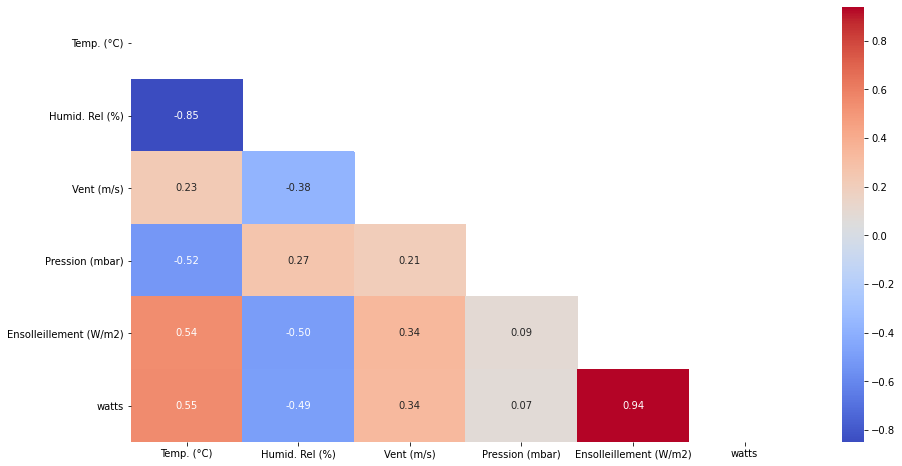

In [86]:
import seaborn as sns

corr = df_etude.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

On remarque que la puissance est fortement corrélé avec :
- L'ensoleillement
- La température
- L'humidité relative

Par ailleurs, la puissance est très faiblement corrélée avec l'humidité relative. On peut donc envisager de garder l'ensoleillement, la température et l'humidité relative,  et de retirer la pression.

**2. Corrélation entre les variables restantes**

Regardons maintenant les corrélations entre les variables restantes :

In [ ]:
df_etude.iloc[:,-1:]

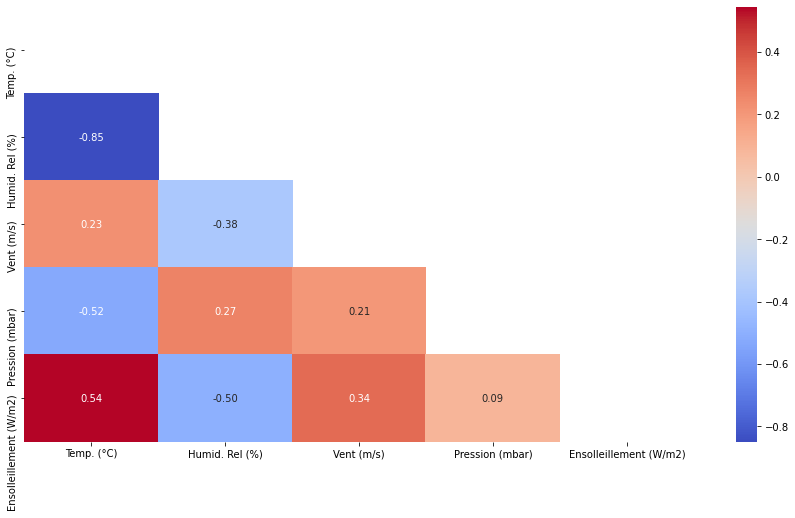

In [91]:
import seaborn as sns

corr = df_etude.iloc[:,:-1].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

On remarque que l'ensoleillement est très corrélé avec l'humidité relative. On peut donc envisager de supprimer l'un des deux.  
On peut par exemple essayer de garder :
- L'ensoleillement
- La température

# Identification des variables les plus importantes par Random Forest

**1. Création des données X et Y**

In [14]:
X = df_etude.iloc[:,0:-1]
X

,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2)
Date,,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0
...,...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0


In [16]:
Y = df_etude.iloc[:,-1:]
Y

,watts
Date,
2018-07-01 00:00:00,0.0
2018-07-01 00:15:00,0.0
2018-07-01 00:30:00,0.0
2018-07-01 00:45:00,0.0
2018-07-01 01:00:00,0.0
...,...
2019-04-13 23:00:00,0.0
2019-04-13 23:15:00,0.0
2019-04-13 23:30:00,0.0


**1. Choix du nombre d'arbres**

On commence par regarder comment évolue le score sur une 10ène d'essais avec un nombre d'arbres croissant :

In [94]:
# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables

n_arbres_max = 500

n_arbres = np.linspace(50,n_arbres_max,10).astype(np.int32)
mtry = np.sqrt(p).astype(np.int32)
OOB_err = []

for i in n_arbres:
  print("#Arbres : %d" %i)
  clf = RandomForestRegressor(n_estimators=i, bootstrap=True, oob_score=True, max_samples = n, max_features = mtry, n_jobs=-1)
  clf.fit(X,tf.squeeze(np.asarray(Y),1))
  OOB_err.append(1 - clf.oob_score_)

#Arbres : 50
#Arbres : 100
#Arbres : 150
#Arbres : 200
#Arbres : 250
#Arbres : 300
#Arbres : 350
#Arbres : 400
#Arbres : 450
#Arbres : 500


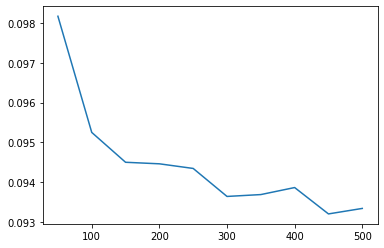

In [95]:
plt.plot(n_arbres,OOB_err)

On choisir n_arbres = 500 et on utilise m_try = 5

# Importance des variables - Pemière approche : Importance sans permutations

**1. Entrainement de la forêt**

In [100]:
from sklearn.inspection import permutation_importance

# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables
n_arbres = 500
m_try = 5

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
clf.fit(X,tf.squeeze(np.asarray(Y),1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

**2. Affichage de l'importance des variables**

In [101]:
col_sorted_by_importance=clf.feature_importances_.argsort()
feat_imp = pd.DataFrame({'cols':X.columns[col_sorted_by_importance],'imps':clf.feature_importances_[col_sorted_by_importance]})
feat_imp

,cols,imps
0,Pression (mbar),0.013912
1,Vent (m/s),0.020009
2,Humid. Rel (%),0.027583
3,Temp. (°C),0.027701
4,Ensolleillement (W/m2),0.910795


In [102]:
!pip install plotly_express --upgrade -q

In [103]:
import plotly_express as px
import plotly.offline as po

px.bar(feat_imp.sort_values(['imps'], ascending=False)[:30], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

# Importance des variables - Deuxième approche : Méthode par permutations des importances

Permutation importance is a technique where we shuffle the values of a single column and run the model to see how the scores get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

Let us see the feature importances for recall score on the test dataset.

In [104]:
import random

def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=clf.score(X,y)
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score = clf.score(X1,y)
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import progressbar

baseline, scores = PermImportance(X, tf.squeeze(np.asarray(Y),1), clf, recall_score, num_iterations=10)

 80% (4 of 5) |####################      | Elapsed Time: 0:00:14 ETA:   0:00:03

In [106]:
percent_changes={c:[] for c in X.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [107]:
pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)

,variable,value
0,Ensolleillement (W/m2),171.007927
3,Temp. (°C),10.140966
1,Humid. Rel (%),7.921568
2,Pression (mbar),4.349316
4,Vent (m/s),3.531353


In [108]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False),
    x='variable',y='value',labels={'variable':'column','value':'% change in recall'})

# Comparaison entre les deux méthodes

In [109]:
# Calcul des écarts-types et des moyennes
scores_std = {}
scores_mean = {}
for element in scores:
  scores_std[element] = np.std(scores[element])
  scores_mean[element] = np.mean(scores[element])

df_perm = pd.DataFrame.from_dict([scores_std, scores_mean]).transpose()
df_perm = df_perm.rename(columns={0:"std",1:"mean"})
df_perm = df_perm.sort_values(by=['mean'],ascending=False)
df_perm

,std,mean
Ensolleillement (W/m2),0.010178,1.687422
Temp. (°C),0.000921,0.100066
Humid. Rel (%),0.000844,0.078166
Pression (mbar),0.000465,0.042917
Vent (m/s),0.000327,0.034846


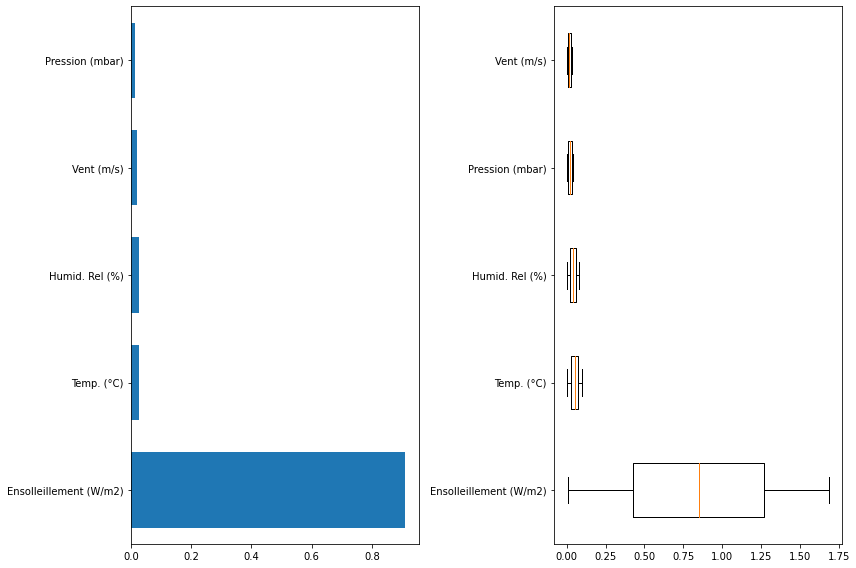

In [110]:
feature_perm = df_perm
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp

tree_indices = np.arange(0, len(feature_imp)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,feature_imp['imps'].values, height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_imp['cols'].values)
ax1.set_ylim((0, len(feature_imp)))

ax2.boxplot(feature_perm, vert=False,labels=feature_perm.index.values)
fig.tight_layout()
plt.show()

# Sélection des variables par méthode RFE

In [111]:
from sklearn.feature_selection import RFE

# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables
n_arbres = 500
m_try = "auto"

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
rfe = RFE(estimator=clf, n_features_to_select=3, step=1, verbose=1)
rfe.fit(X, tf.squeeze(np.asarray(Y),1))

Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=500, n_jobs=-1, oob_score=True,
                                    random_state=None, verbose=0,
                                    warm_start=False),
    n_features_to_select=3, step=1, verbose=1)

In [69]:
X

,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2)
Date,,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0
...,...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0


In [112]:
rfe.ranking_

array([1, 1, 2, 3, 1])

# Sélection des variables par méthode RFE-CV

In [113]:
from sklearn.feature_selection import RFECV

# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables
n_arbres = 500
m_try = 5
min_features_to_select = 1

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features="auto", n_jobs=-1)
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_absolute_error',min_features_to_select=min_features_to_select, verbose=1)
rfecv.fit(X, tf.squeeze(np.asarray(Y),1))

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFECV(cv=5,
      estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=500, n_jobs=-1,
                                      oob_score=True, random_state=None,
                                      verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_absolute_error',
      step=1, verbose=1)

Optimal number of features : 3


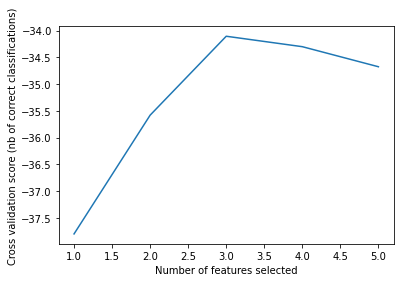

In [114]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [115]:
rfecv.ranking_

array([1, 1, 2, 3, 1])

# Sélection des variables par tests de collinéarité VIF

In [117]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function for removing features with high vif
def drop_high_vif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

#function for listing vif values
def vif_values(X):
    add_constant(X)
    df=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return df


In [123]:
X_reduit_VIF = drop_high_vif(X,thresh=20)
X_reduit_VIF

dropping 'Pression (mbar)' at index: 3
Remaining variables:
Index(['Temp. (°C)', 'Humid. Rel (%)', 'Vent (m/s)', 'Ensolleillement (W/m2)'], dtype='object')


,Temp. (°C),Humid. Rel (%),Vent (m/s),Ensolleillement (W/m2)
Date,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,0.0
...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,0.0


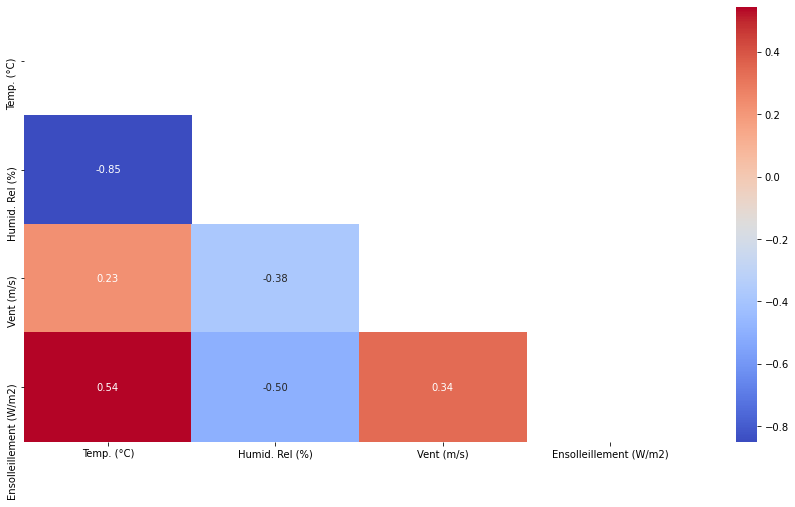

In [124]:
import seaborn as sns

corr = X_reduit_VIF.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

# Analyse de la série

**1. ACF & PACF**

In [ ]:
# ACF & PACF du bruit blanc

serie = df_etude['watts'].values

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie, ax=ax1, lags = range(0,500))
ax1.set_title("Autocorrélation")

plot_pacf(serie, ax=ax2, lags = range(0, 500))
ax2.set_title("Autocorrélation partielle")

# Séparation des données de test et d'entrainement

In [ ]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude['watts'].values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude['watts'].values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude['watts'].values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
serie_entrainement_X_norm = min_max_scaler.fit_transform(tf.reshape(serie_entrainement_X,shape=(len(serie_entrainement_X),1)))
serie_test_X_norm = min_max_scaler.fit_transform(tf.reshape(serie_test_X,shape=(len(serie_test_X),1)))

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm, label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm, label="X_Val")

ax.legend()
plt.show()

# Création des datasets

In [ ]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle

def prepare_dataset_XY(series, longueur_sequence, longueur_sortie, batch_size,shift):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  dataset = dataset.map(lambda x: (x[0:longueur_sequence][:,:],tf.expand_dims(x[-longueur_sortie:][:,0],1)))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [ ]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 5*24*4      # 4 jours (288*15min)
longueur_sortie = 12*4        # 12h
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm,longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm,longueur_sequence,longueur_sortie,batch_size,shift)

In [ ]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0].shape)
  print(element[1].shape)

In [ ]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0].shape)
  print(element[1].shape)

On extrait maintenant les deux tenseurs (X,Y) pour l'entrainement :

In [ ]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # #60x((32,5,779),(32,5,1)) => x = 60x(32,5,779) ; y = 60x(32,5,1)

# Recombine les données
x = np.asarray(x,dtype=np.float32)      # 60x(32,5,779) => (60,32,5,779)
y = np.asarray(y,dtype=np.float32)      # 60x(32,5,1) => (60,32,5,1)

x_train = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],longueur_sequence,x.shape[3])))     # (60,32,5,779) => (60*32,5,779)
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))     # (60,32,5,1) => (60*32,5,1)

# Affiche les formats
print(x_train.shape)
print(y_train.shape)

Puis la même chose pour les données de validation :

In [ ]:
# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))

# Recombine les données
x = np.asarray(x,dtype=np.float32)
y = np.asarray(y,dtype=np.float32)

x_val = np.asarray(tf.reshape(x,shape=(x.shape[0]*x.shape[1],longueur_sequence,x.shape[3])))
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val.shape)
print(y_val.shape)

# Affichage des séries

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

for i in range(0,3):
  ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence),x_train[i],label="X_train")
  ax.plot(np.linspace(longueur_sequence,longueur_sequence+longueur_sortie-1,longueur_sortie),y_train[i],label="Y_train")

ax.legend()
plt.show()

# Création du modèle Seq2Seq basique (avec encodeur simple GRU)

Notre modèle Séquence vers Séquence est composé :
- D'un encodeur, qui comprend une couche GRU uni-directionnelle
- D'un décodeur, qui comprend une couche GRU uni-directionnelle. De plus, deux couches denses sont utilisées pour recréer la sortie univariée à partir des sorties des cellules GRU.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_basique_2.png?raw=true' />

**1. Création de la couche d'encodeur**

In [ ]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="GRU_Encodeur")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_enc : Sortie encodeur       : (batch_size,1,128)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self, input, hidden=None):
    out_enc, out_hid = self.couche_GRU(input,initial_state=hidden)
    return out_enc, out_hid


**2. Création de la couche de décodeur**

In [ ]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_GRU, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_GRU = dim_GRU            # Dimension des vecteurs cachés
    self.drop = drop
    self.init_state = True
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_GRU = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="GRU_Decodeur")
    self.couche_Dense = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul),input_dim=self.dim_GRU)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,128)
  #     out_hid : Sortie vecteur caché  : (batch_size,128)
  def call(self,input,hidden=None):
    if self.init_state == True:
      out_dec, out_hid = self.couche_GRU(input)
      self.init_state = False
    else:
      out_dec, out_hid = self.couche_GRU(input,initial_state=hidden)
    out_dec = self.couche_Dense(out_dec)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [ ]:
class Net_GRU(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    self.dim_GRU = dim_GRU
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:      Entrée réseau         : (batch_size,longueur_sequence,1) 
  #     output_seq  Sorties réelles       : (batch_size, longueur_sortie,1)
  # Sorties :
  def call(self,input,output_seq,training=False):
    longueur_entree = input.shape[1]
    sortie = []

    enc_out, enc_hid = self.encodeur(input[:,0:1,:])

    for i in range(1,longueur_entree):
      enc_out, enc_hid = self.encodeur(input[:,i:i+1,:],enc_hid)

    dec_input = tf.expand_dims(input[:,-1,:],1)
    dec_hid = enc_hid

    if (training == False):
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, dec_hid)
        dec_input = tf.expand_dims(dec_out,-1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    else:
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, dec_hid)
        dec_input = tf.expand_dims(output_seq[:,i,:],1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))

    return sortie

**4. Création du modèle**

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Calcul du gradient
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Optimisation des poids
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data

        # Calcul des predictions
        y_pred = self(x, training=False)

        # Mise à jour des erreurs
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

In [ ]:
dim_GRU = 128
drop=0.2
l2reg=0.001

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))
  sorties_sequences = tf.keras.layers.Input(shape=(longueur_sortie,1))
  encodeur = Encodeur(dim_GRU=dim_GRU,drop=drop,regul=l2reg)
  decodeur = Decodeur(dim_GRU=dim_GRU,drop=drop,regul=l2reg)
  sortie = Net_GRU(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie)(entrees_sequences,sorties_sequences)
  model = CustomModel([entrees_sequences,sorties_sequences],sortie)
  return model

# Création du modèle Seq2Seq basique avec encodeur LSTM-Bidirectionnel

Notre modèle Séquence vers Séquence est composé :
- D'un encodeur, qui comprend une couche GRU uni-directionnelle
- D'un décodeur, qui comprend une couche GRU uni-directionnelle. De plus, deux couches denses sont utilisées pour recréer la sortie univariée à partir des sorties des cellules GRU.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_basique_2.png?raw=true' />

**1. Création de la couche d'encodeur à base de LSTM**

La couche Bidirectionnelle appliquée à une couche LSTM retourne 5 tenseurs :
- La concaténation (ou la somme, en fonction de la méthode `merge` choisie) des états cachés avance / recul
- Le dernier état caché du LSM d'avance : (batch_size, dim_LSTM*2) si concaténation ou (batch_size,dim_LSTM) si merge
- Le derner cell-state du LSTM d'avance : (batch_size, dim_LSTM)
- Le dernier état caché du LSTM de recul : (batch_size, dim_LSTM)
- Le dernier cell-state du LSTM de recul : (batch_size, dim_LSTM)

In [ ]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="LSTM_Encodeur"),merge_mode="sum")
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée encodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_enc :   Sortie encodeur       : (batch_size,128)
  #     out_hid_x : Sortie vecteur caché  : (batch_size,128)
  #     state_c_x : Sortie cell state     : (btach_size,128)
  def call(self, input, hidden=None):
    out_enc, out_hid_1, state_c_1, out_hid_2, state_c_2 = self.couche_LSTM(input,initial_state=hidden)
    return out_enc, out_hid_1, state_c_1, out_hid_2, state_c_2


**2. Création de la couche de décodeur**

In [ ]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    self.drop = drop
    self.init_state = True
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,name="LSTM_Decodeur")
    self.couche_Dense = tf.keras.layers.Dense(units=1,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Entrée décodeur       : (batch_size,1,1) 
  #     hidden:   Vecteur caché         : (batch_size,1,128)
  # Sorties :
  #     out_dec : Sortie décodeur       : (batch_size,1,1)
  #     out_hid : Sortie vecteur caché  : (batch_size,1,128)
  def call(self,input,hidden=None):
    if self.init_state == True:
      out_dec, out_hid, state_c = self.couche_LSTM(input)
      self.init_state = False
    else:
      out_dec, out_hid, state_c = self.couche_LSTM(input,initial_state=hidden)
    out_dec = self.couche_Dense(out_dec)
    return out_dec, out_hid

**3. Création de la couche réseau**

In [ ]:
class Net_LSTM(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, longueur_sortie, regul=0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.longueur_sortie = longueur_sortie
    self.regul = regul
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:      Entrée réseau         : (batch_size,longueur_sequence,1) 
  #     output_seq  Sorties réelles       : (batch_size, longueur_sortie,1)
  # Sorties :
  def call(self,input,output_seq,training=False):
    longueur_entree = input.shape[1]
    sortie = []

    enc_out, enc_hid_1, enc_state_1, enc_hid_2, enc_state_2 = self.encodeur(input[:,0:1,:])

    for i in range(1,longueur_entree):
      enc_out, enc_hid_1, enc_state_1, enc_hid_2, enc_state_2 = self.encodeur(input[:,i:i+1,:],[enc_hid_1, enc_state_1, enc_hid_2, enc_state_2])

    dec_input = tf.expand_dims(input[:,-1,:],1)
    dec_hid = tf.keras.layers.Add()((enc_hid_1,enc_hid_2))
    dec_state = tf.keras.layers.Add()((enc_state_1,enc_state_2))

    if (training == False):
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, [dec_hid,dec_state])
        dec_input = tf.expand_dims(dec_out,-1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))
    else:
      for i in range(0,self.longueur_sortie):
        dec_out, dec_hid = self.decodeur(dec_input, [dec_hid,dec_state])
        dec_input = tf.expand_dims(output_seq[:,i,:],1)
        sortie.append(dec_out)
      sortie = tf.convert_to_tensor(tf.transpose(sortie, perm=[1,0,2]))

    return sortie

**4. Création du modèle**

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Calcul du gradient
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Optimisation des poids
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data

        # Calcul des predictions
        y_pred = self(x, training=False)

        # Mise à jour des erreurs
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Mise à jour des métriques
        self.compiled_metrics.update_state(y, y_pred)

        # Retourne un dictionnaire avec les résultats
        return {m.name: m.result() for m in self.metrics}

In [ ]:
dim_LSTM = 128
drop=0.2
l2reg=0.001


def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,1))
  sorties_sequences = tf.keras.layers.Input(shape=(longueur_sortie,1))


  encodeur = Encodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
  decodeur = Decodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)

  sortie = Net_LSTM(encodeur,decodeur,longueur_sequence=longueur_sequence, longueur_sortie=longueur_sortie)(entrees_sequences,sorties_sequences)

  model = CustomModel([entrees_sequences,sorties_sequences],sortie)
  return model

# Entrainement avec TPU

In [ ]:
from google.colab import files

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()
  max_periodes = 1000

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train,y_train],y=y_train,validation_data=([x_val,y_val],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)],batch_size=batch_size)

files.download('poids_train.hdf5')

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train,y_train],y=y_train)
model.evaluate(x=[x_val,y_val],y=y_val)

# Chargement du modèle pré-entrainé

**1. Seq2Seq Basique - Encodeur unidirectionnel GRU**

**Seq2Seq_Basique_GRU128_DR02_L2_001_BS128_EP1000_5J_12H :**
- Encodeur unidirectionnel GRU #128
- Longueur entrée : 5 jours
- Longueur sortie : 24h
- Drop : 0.2
- L2 : 0.01
- Batch Size : 128
- Périodes : 1000  
=> mse : 0.0227 / 0.0289  
  
  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_Basique_GRU.png?raw=true' width=500/>

In [ ]:
model = get_model()

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Modeles/Seq2Seq_Basique_GRU128_DR02_L2_001_BS128_EP1000_5J_12H.hdf5"

In [ ]:
model.load_weights("Seq2Seq_Basique_GRU128_DR02_L2_001_BS128_EP1000_5J_12H.hdf5")

**2. Seq2Seq Basique - Encodeur LSTM Bidirectionnel**

**Seq2Seq_Basique_LSTMBiDir128_DR02_L2_001_BS128_EP1000_5J_12H :**
- Encodeur Bi-directionnel LSTM #128
- Longueur entrée : 5 jours
- Longueur sortie : 24h
- Drop : 0.2
- L2 : 0.01
- Batch Size : 128
- Périodes : 1000  
=> mse : 0.0072 / 0.0131
  
  
  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Seq2Seq/images/Seq2Seq_Basique_LSTMBiDir.png?raw=true' width=500/>

In [ ]:
model = get_model()

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Modeles/Seq2Seq_Basique_LSTMBiDir128_DR02_L2_001_BS128_EP1000_5J_12H.hdf5"

In [ ]:
model.load_weights("Seq2Seq_Basique_LSTMBiDir128_DR02_L2_001_BS128_EP1000_5J_12H.hdf5")

# Prédictions multi-step

In [ ]:
pred_ent = model.predict([x_train,y_train],verbose=1)
pred_val = model.predict([x_val,y_val],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = longueur_sortie

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,0],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_ent)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[longueur_sequence+i*longueur_sortie:longueur_sequence+(i+1)*longueur_sortie])
  step_val.append(pred_ent[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[longueur_sequence+i*longueur_sortie])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pd.to_datetime(pred_index),y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))


#Affiche les prédictions sur les validations
pred = []
pred_index = []
step_time = []
step_val = []
max = int(len(pred_val)/longueur_sortie)
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i*longueur_sortie,0:decalage,:],1))
  pred_index.append(df_etude.index[temps_separation+i*decalage+longueur_sequence:temps_separation+i*decalage+longueur_sequence+longueur_sortie])
  step_val.append(pred_val[i*longueur_sortie,0,0])
  step_time.append(df_etude.index[temps_separation+i*decalage+longueur_sequence])

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))
pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pd.to_datetime(pred_index),y=pred, mode='lines', line=dict(color='green', width=1)))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1)))



fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Prédictions single-step

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,0],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,0],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()